___
# <center><a>DQN<a/>
___

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import trange
import torch
from torch.utils.tensorboard import SummaryWriter
import ray
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.algorithms.dqn.torch.default_dqn_torch_rl_module import DefaultDQNTorchRLModule
from ray.rllib.core.rl_module.rl_module import RLModuleSpec


ray.shutdown()
%load_ext tensorboard
%matplotlib inline

___
## <center><a>Среда<a/>
___

Obseravtion space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


/home/nazarov/Github/RLCourse/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


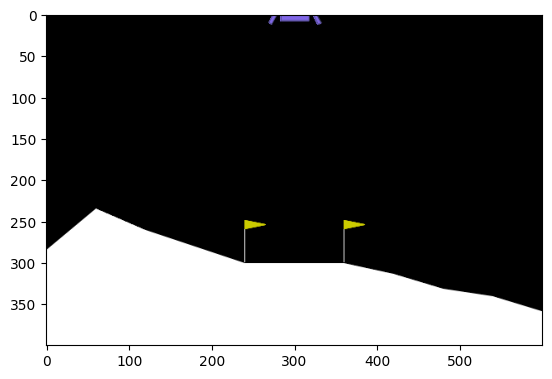

In [3]:
env_name = "LunarLander-v3"
env = gym.make(env_name, render_mode="rgb_array")
env.reset()

print(f"Obseravtion space: {env.observation_space}")
print(f"Action space: {env.action_space}")
plt.imshow(env.render())
plt.grid(visible=False)
plt.show();
# env.close()

___
## <center><a>Нейронная сеть<a/>
___

In [9]:
obs_space = gym.spaces.Box(-float('inf'), float('inf'), shape=(8,))
act_space = gym.spaces.Discrete(4)

model_config  ={
    'fcnet_hiddens':[128, 64], #128, 64
    'fcnet_activation':'relu',
    'head_fcnet_hiddens':[32], #32
    'head_fcnet_activation': 'silu',
    'vf_share_layers':False,
    'num_atoms':1,
    'epsilon':[
        (0, 1),
        (50_000, 1),
        (100_000, 0.1),
        (400_000, 0.05),
        (600_000, 0.01),
        ],
}

rl_module_spec = RLModuleSpec(
    module_class=DefaultDQNTorchRLModule,
    model_config=model_config ,
    observation_space=obs_space,
    action_space=act_space,
)


___
## <center><a>Алгоритм<a/>
___

In [10]:
if ray.is_initialized():
    ray.shutdown()

num_gpus = 1 if torch.cuda.is_available() else 0
num_gpus = 0
ray.init(num_gpus=num_gpus, ignore_reinit_error=True, log_to_driver=True)

dqn_config = (
    DQNConfig()
    .debugging(seed=0)
    .framework('torch')
    .environment(env=env_name)
    .api_stack(enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True)
    .resources(num_gpus=num_gpus)
    .rl_module(rl_module_spec=rl_module_spec)
    .env_runners(
        num_env_runners=1,
        num_envs_per_env_runner=1,
        create_env_on_local_worker=True,
        rollout_fragment_length=30,
        batch_mode="truncate_episodes",
        )
    .learners(num_gpus_per_learner=num_gpus)
    .fault_tolerance(max_num_env_runner_restarts=0)
    .training(
        train_batch_size=1000,
        gamma=0.99,
        n_step=1,
        lr=[[0, 5e-3], [300_000, 1e-3], [600_000, 1e-4]],
        dueling= True,
        double_q= True,
        target_network_update_freq=0,
        tau=0.005,
        num_steps_sampled_before_learning_starts= 10_000,
        replay_buffer_config={
            'type' : 'PrioritizedEpisodeReplayBuffer',
            'capacity' : 50_000,
            "alpha": 0.5,
            "beta": 0.05,
            },
        epsilon=[
        (0, 1),
        (50_000, 1),
        (100_000, 0.1),
        (400_000, 0.05),
        (600_000, 0.01),
            ],
        training_intensity=1
        )
    .evaluation(
    evaluation_interval=50,
    evaluation_duration=30,
    evaluation_duration_unit="episodes",
    evaluation_config={"explore": False},
    )
)

algo = dqn_config.build_algo()
writer = SummaryWriter(log_dir='/home/nazarov/Github/RLCourse/Practice/2. DQN/ray_results')

2025-12-31 01:41:15,230	INFO worker.py:2004 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/nazarov/Github/RLCourse/.venv/lib/python3.13/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/nazarov/Github/RLCourse/.venv/lib/python3.13/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/hom

___
## <center><a>Обучение<a/>
___

In [11]:
max_iter = 900
beta_decay = 20
con = algo.get_config()
beta_start = dict(con)['replay_buffer_config']['beta']

for i in trange(max_iter):

    con = algo.get_config()

    # beta = dict(con)['replay_buffer_config']['beta']

    beta = min(1, max(beta_start, i / ((max_iter - 1) * beta_decay)))
    dict(con)['replay_buffer_config']['beta'] = beta
    algo.set_state(con)

    result = algo.train()
    reward_mean = result['env_runners']['episode_return_mean']
    len_mean = result['env_runners']['episode_len_mean']

    writer.add_scalar("train_return_mean", reward_mean, i , new_style=True)
    writer.add_scalar("train_len_mean", len_mean, i , new_style=True)
    writer.add_scalar("beta", beta, i , new_style=True)


    try:
        total_loss = result['learners']['default_policy']['total_loss']
        td_error_mean = result['learners']['default_policy']['td_error_mean']
        writer.add_scalar("total_loss", total_loss, i , new_style=True)
        writer.add_scalar("td_error_mean", td_error_mean, i , new_style=True)
    except KeyError:
        print('Sampling before training ...')
        continue
    try:
        eval_result = result['evaluation']

        eval_return_mean = eval_result['env_runners']['episode_return_mean']
        eval_len_mean = eval_result['env_runners']['episode_len_mean']

        writer.add_scalar("eval_return_mean", eval_return_mean, i , new_style=True)
        writer.add_scalar("eval_len_mean", eval_len_mean, i , new_style=True)
    except KeyError:
        continue

writer.flush()
writer.close()
algo.stop()

  0%|          | 1/900 [00:01<17:32,  1.17s/it]

Sampling before training ...


  0%|          | 2/900 [00:02<17:26,  1.17s/it]

Sampling before training ...


  0%|          | 3/900 [00:03<17:28,  1.17s/it]

Sampling before training ...


  0%|          | 4/900 [00:04<17:31,  1.17s/it]

Sampling before training ...


  1%|          | 5/900 [00:05<17:32,  1.18s/it]

Sampling before training ...


  1%|          | 6/900 [00:07<17:33,  1.18s/it]

Sampling before training ...


  1%|          | 7/900 [00:08<17:36,  1.18s/it]

Sampling before training ...


  1%|          | 8/900 [00:09<17:33,  1.18s/it]

Sampling before training ...


  1%|          | 9/900 [00:10<17:33,  1.18s/it]

Sampling before training ...


100%|██████████| 900/900 [31:01<00:00,  2.07s/it]  


___
## <center><a>Результаты<a/>
___

In [5]:
%tensorboard --logdir='./ray_results'

Reusing TensorBoard on port 6006 (pid 9721), started 0:00:02 ago. (Use '!kill 9721' to kill it.)

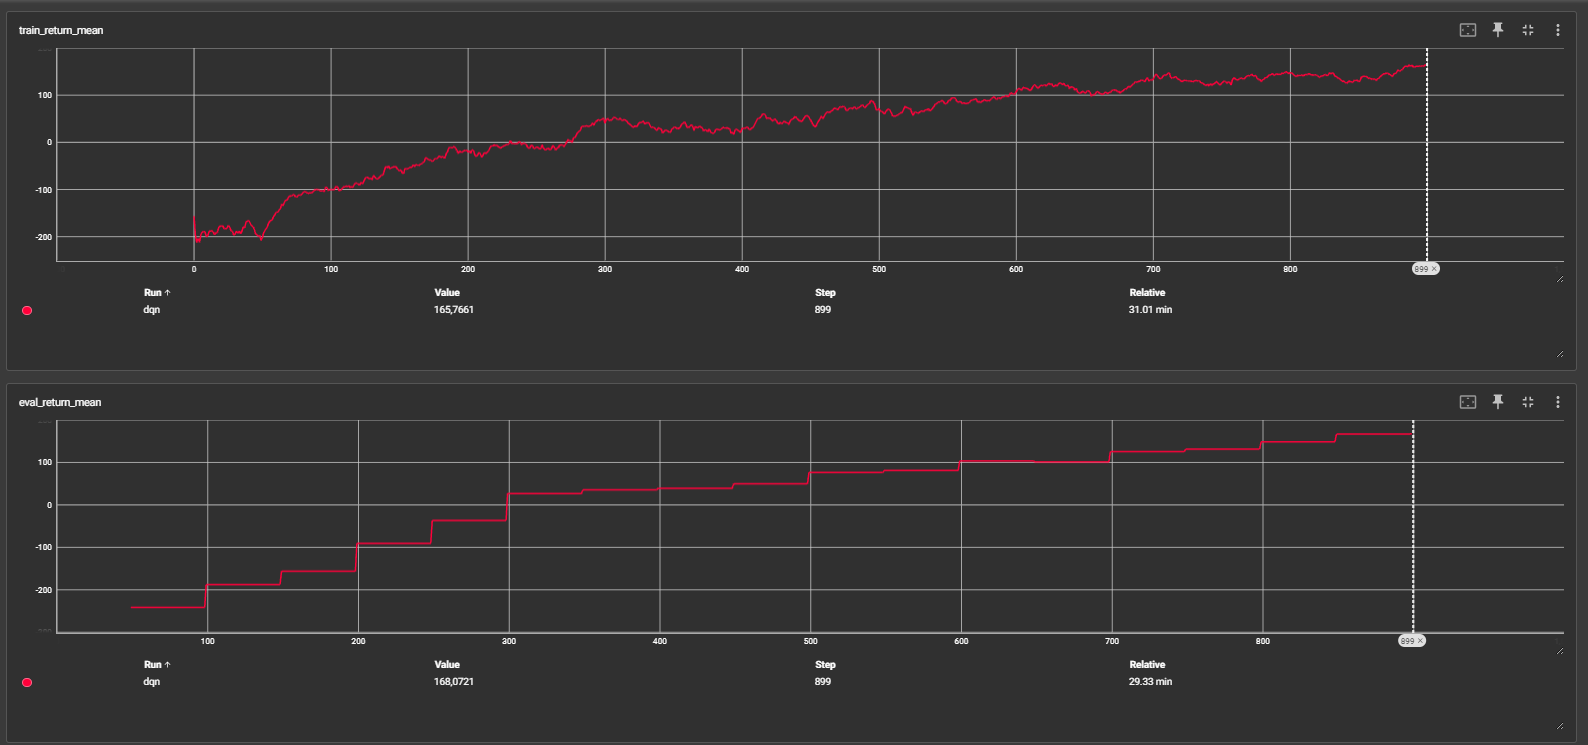